In [49]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

In [50]:

######## Simulation parameters ########
neurons_per_pop = 10
n_pop = 6
n_batches = 300
T = 50
mean_fr = .1

######## Defining coordinate system ########
rads = torch.linspace(0, 2*torch.pi, n_pop+1)
mean_locations_pop = torch.zeros(n_pop, 2)
coordinates = torch.zeros(neurons_per_pop*n_pop, 2)
for i in range(n_pop):
    mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
    coordinates[neurons_per_pop * i:neurons_per_pop * (i + 1), :] = 0.15 * torch.randn(neurons_per_pop, 2) + mean_locations_pop[i]

######## Start creating data ########
data = torch.zeros(neurons_per_pop*n_pop, T, n_batches)
for batch in range(n_batches):

    ######## Creating random input currents and mother trains ########
    t = np.linspace(0, 10*np.pi, T)
    fr = np.zeros((n_pop, T))
    mother = np.zeros((n_pop, T))
    for pop in range(n_pop):
        u = np.random.rand()
        phase = np.random.randn()
        amp = .1*np.random.rand()
        shift = .3*np.random.rand()
        fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        while np.min(fr[pop, :]) < 0:
            u = np.random.rand()
            phase = np.random.randn()
            amp = .1*np.random.rand()
            shift = .3*np.random.rand()
            fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        mother[pop, :] = np.random.poisson(fr[pop, :])


    # empty data array
    spikes = np.zeros((neurons_per_pop*n_pop, T))

    # Excitatory and inhibitory connections
    inh = [[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]]
    exc = [[3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5]]
    for pop in range(n_pop):
        delete_spikes = np.roll(np.sum(fr[inh[pop], :], 0), 1) * np.ones((neurons_per_pop, T)) >= np.random.uniform(0, 1, size=(neurons_per_pop, T))
        noise = np.random.poisson(np.roll(np.sum(fr[exc[pop], :], 0), 1), (neurons_per_pop, T))
        temp = np.tile(mother[pop, :], (neurons_per_pop, 1)) - delete_spikes + noise
        spikes[pop*neurons_per_pop:(pop+1)*neurons_per_pop, :] = temp[np.argsort(np.mean(temp, 1)), :]
    spikes[spikes < 0] = 0
    spikes[spikes > 1] = 1

    data[:, :, batch] = torch.tensor(spikes)
print(torch.mean(data))


tensor(0.3205)


In [51]:
from data.reshape_data import reshape
from data.reshape_data import resample

data_nsr = resample(data, 10, mode=1)

ImportError: cannot import name 'reshape' from 'data.reshape_data' (C:\Users\sebas\RU\intern\data\reshape_data.py)

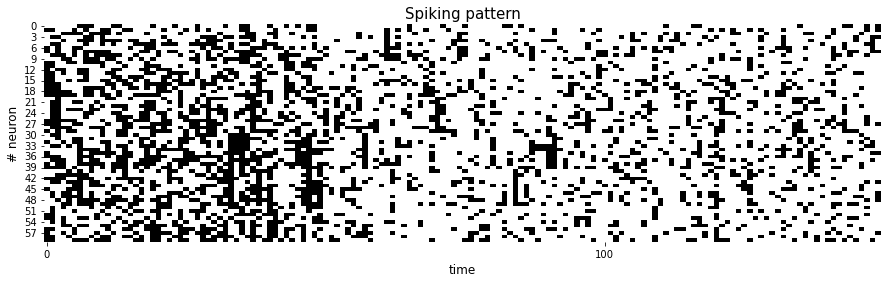

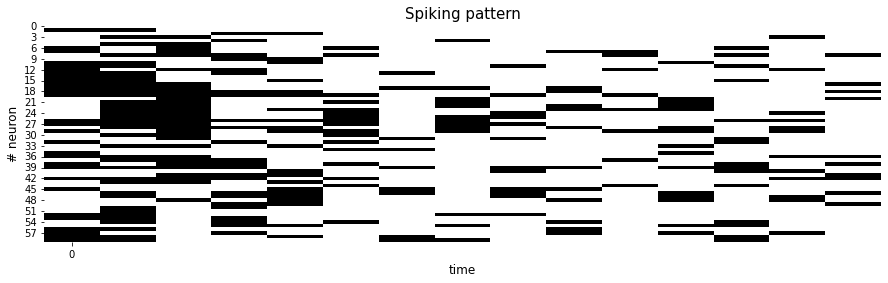

In [44]:
raster_plot(torch.cat((data[:,:,0], data[:,:,1], data[:,:,2]), 1))
plt.show()
raster_plot(torch.cat((data_nsr[:,:,0], data_nsr[:,:,1], data_nsr[:,:,2]), 1))
plt.show()


C:\Users\sebas\anaconda3\envs\RTRBM\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


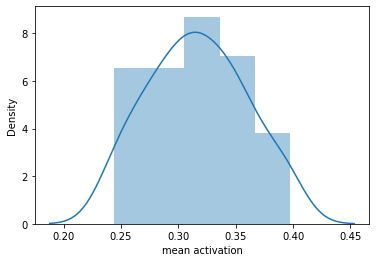

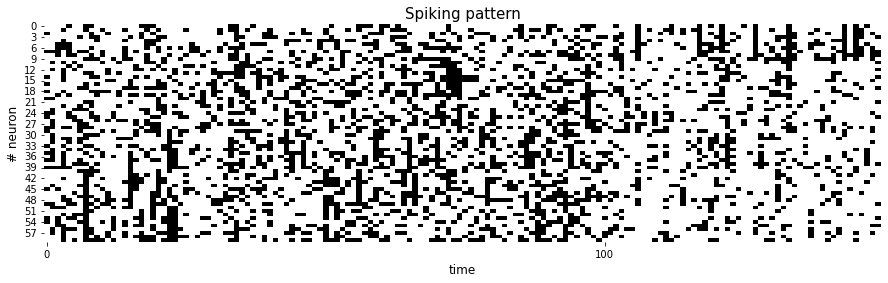

In [3]:
sns.distplot(torch.mean(data, (1, 2)))
plt.xlabel('mean activation')
plt.show()

raster_plot(torch.cat((data[:,:,0], data[:,:,1], data[:,:,2]), 1))
plt.show()

In [5]:
rtrbm = RTRBM(data, N_H=6, device='cpu')
rtrbm.learn(n_epochs=3000, batchsize=10, lr=1e-4)

  0%|          | 2/3000 [00:12<5:04:35,  6.10s/it]


KeyboardInterrupt: 